In [1]:
import sys; sys.path.append('../rrr')
from multilayer_perceptron import *
from figure_grid import *
from local_linear_explanation import *
from toy_colors import generate_dataset, imgshape, ignore_rule1, ignore_rule2, rule1_score, rule2_score
import lime
import lime.lime_tabular

# Toy Color Dataset

This is a simple, two-class image classification dataset with two independent ways a model could learn to distinguish between classes. The first is whether all four corner pixels are the same color, and the second is whether the top-middle three pixels are all different colors. Images in class 1 satisfy both conditions and images in class 2 satisfy neither. See `color_dataset_generator` for more details.

We will train a multilayer perceptron to classify these images, explore which rule(s) it implicitly learns, and constrain it to use only one rule (or neither).

Let's first load our dataset:

In [2]:
X, Xt, y, yt = generate_dataset(cachefile='../data/toy-colors.npz')
E1 = np.array([ignore_rule2 for _ in range(len(y))])
E2 = np.array([ignore_rule1 for _ in range(len(y))])

In [3]:
print(X.shape, Xt.shape, y.shape, yt.shape, E1.shape, E2.shape)

(20000, 75) (20000, 75) (20000,) (20000,) (20000, 75) (20000, 75)


## Understanding the Dataset

Let's just examine images from each class quickly and verify that in class 1, the corners are all the same color and the top-middle three pixels are all different (none of which should hold true in class 2):

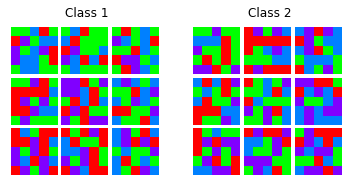

In [4]:
plt.subplot(121)
plt.title('Class 1')
image_grid(X[np.argwhere(y == 0)[:9]], (5,5,3), 3)
plt.subplot(122)
plt.title('Class 2')
image_grid(X[np.argwhere(y == 1)[:9]], (5,5,3), 3)
plt.show()

Great.

## Explaining and learning diverse classifiers

Now let's see if we can train our model to implicitly learn each rule:

In [5]:
def explain(model, title='', length=4):
  plt.title(title)
  explanation_grid(model.grad_explain(Xt[:length*length]), imgshape, length)

In [6]:
# Train a model without any constraints
mlp_plain = MultilayerPerceptron()
mlp_plain.fit(X, y)
mlp_plain.score(Xt, yt)

[                    ] 0%Iteration=0, crossentropy=Autograd ArrayBox with value 2895.1379211216276, rightreasons=Autograd ArrayBox with value 0.0, smallparams=Autograd ArrayBox with value 0.005468341253458463, lenX=1.0
[                    ] 3%Iteration=200, crossentropy=Autograd ArrayBox with value 76.32030306200001, rightreasons=Autograd ArrayBox with value 0.0, smallparams=Autograd ArrayBox with value 0.005374211385084448, lenX=1.0
[=                   ] 7%Iteration=400, crossentropy=Autograd ArrayBox with value 10.601440879023187, rightreasons=Autograd ArrayBox with value 0.0, smallparams=Autograd ArrayBox with value 0.005404604051830186, lenX=1.0
[==                  ] 11%Iteration=600, crossentropy=Autograd ArrayBox with value 7.237446556798012, rightreasons=Autograd ArrayBox with value 0.0, smallparams=Autograd ArrayBox with value 0.005438986213968153, lenX=1.0
[===                 ] 15%Iteration=800, crossentropy=Autograd ArrayBox with value 1.1042320152655258, rightreasons=Aut

0.99975

In [7]:
# Train a model constrained to use the first rule
mlp_rule1 = MultilayerPerceptron(l2_grads=1000)
mlp_rule1.fit(X, y, E1)
mlp_rule1.score(Xt, yt)

[                    ] 0%Iteration=0, crossentropy=Autograd ArrayBox with value 9293.640694778216, rightreasons=Autograd ArrayBox with value 216766.76174253254, smallparams=Autograd ArrayBox with value 0.005270068262835484, lenX=1.0
[                    ] 3%Iteration=200, crossentropy=Autograd ArrayBox with value 215.89600170511585, rightreasons=Autograd ArrayBox with value 215.1582092680998, smallparams=Autograd ArrayBox with value 0.0050068475864097906, lenX=1.0
[=                   ] 7%Iteration=400, crossentropy=Autograd ArrayBox with value 186.76571573829148, rightreasons=Autograd ArrayBox with value 37.67458938536318, smallparams=Autograd ArrayBox with value 0.004986251432974673, lenX=1.0
[==                  ] 11%Iteration=600, crossentropy=Autograd ArrayBox with value 182.59143749938954, rightreasons=Autograd ArrayBox with value 7.483915866669674, smallparams=Autograd ArrayBox with value 0.004980890274167681, lenX=1.0
[===                 ] 15%Iteration=800, crossentropy=Autogr

0.99065

In [8]:
# Train a model constrained to use the second rule
mlp_rule2 = MultilayerPerceptron(l2_grads=1000)
mlp_rule2.fit(X, y, E2)
mlp_rule2.score(Xt, yt)

[                    ] 0%Iteration=0, crossentropy=Autograd ArrayBox with value 5139.496036751097, rightreasons=Autograd ArrayBox with value 355200.0521965656, smallparams=Autograd ArrayBox with value 0.0052629931464598404, lenX=1.0
[                    ] 3%Iteration=200, crossentropy=Autograd ArrayBox with value 256.49664710757924, rightreasons=Autograd ArrayBox with value 1026.0920470756662, smallparams=Autograd ArrayBox with value 0.0049222106071974995, lenX=1.0
[=                   ] 7%Iteration=400, crossentropy=Autograd ArrayBox with value 184.19553719454632, rightreasons=Autograd ArrayBox with value 100.46126524453967, smallparams=Autograd ArrayBox with value 0.004892771319043103, lenX=1.0
[==                  ] 11%Iteration=600, crossentropy=Autograd ArrayBox with value 174.1565630392637, rightreasons=Autograd ArrayBox with value 10.636151601852264, smallparams=Autograd ArrayBox with value 0.004887019060647571, lenX=1.0
[===                 ] 15%Iteration=800, crossentropy=Auto

0.58275

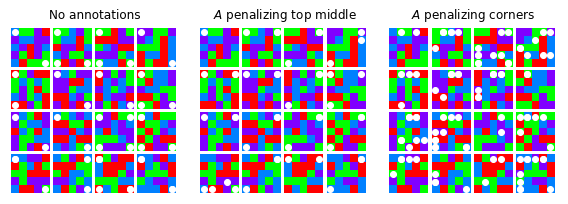

In [10]:
# Visualize largest weights
with figure_grid(1,3, rowwidth=8) as g:
  g.next()
  explain(mlp_plain, 'No annotations')
  g.next()
  explain(mlp_rule1, '$A$ penalizing top middle')
  g.next()
  explain(mlp_rule2, '$A$ penalizing corners')

Notice that when we explicitly penalize corners or the top middle, the model appears to learn the _other_ rule perfectly. We haven't identified the pixels it does treat as significant in any way, but they are significant, so the fact that they show up in the explanations means that the explanation is probably an accurate reflection of the model's implicit logic.

When we don't have any annotations, the model does identify the top-middle pixels occasionally, suggesting it defaults to learning a heavily but not completely corner-weighted combination of the rules.

What happens when we forbid it from using either rule?

In [11]:
mlp_neither = MultilayerPerceptron(l2_grads=1e6)
mlp_neither.fit(X, y, E1 + E2)
mlp_neither.score(Xt, yt)

[                    ] 0%Iteration=0, crossentropy=Autograd ArrayBox with value 2406.892921637919, rightreasons=Autograd ArrayBox with value 226644530.97225633, smallparams=Autograd ArrayBox with value 0.005560782401707594, lenX=1.0
[                    ] 3%Iteration=200, crossentropy=Autograd ArrayBox with value 201.02777504899416, rightreasons=Autograd ArrayBox with value 287946.10196915094, smallparams=Autograd ArrayBox with value 0.005185883876320365, lenX=1.0
[=                   ] 7%Iteration=400, crossentropy=Autograd ArrayBox with value 180.91194632699978, rightreasons=Autograd ArrayBox with value 26001.91335590555, smallparams=Autograd ArrayBox with value 0.005171028793433167, lenX=1.0
[==                  ] 11%Iteration=600, crossentropy=Autograd ArrayBox with value 183.7709399792134, rightreasons=Autograd ArrayBox with value 23815.835604932563, smallparams=Autograd ArrayBox with value 0.005164258407164469, lenX=1.0
[===                 ] 15%Iteration=800, crossentropy=Autogr

0.5078

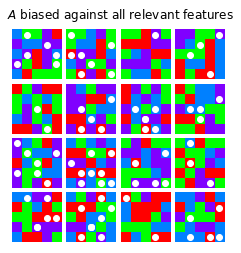

In [12]:
explain(mlp_neither, '$A$ biased against all relevant features')
plt.show()

As we might expect, accuracy goes down and we start identifying random pixels as significant.

## Find-another-explanation

Let's now pretend we have no knowledge of what $A$ _should_ be for this dataset. Can we still train models that use diverse rules just by examining explanations?

In [13]:
A1 = mlp_plain.largest_gradient_mask(X)
mlp_fae1 = MultilayerPerceptron(l2_grads=1000)
mlp_fae1.fit(X, y, A1)
mlp_fae1.score(Xt, yt)

[                    ] 0%Iteration=0, crossentropy=Autograd ArrayBox with value 5197.649051281297, rightreasons=Autograd ArrayBox with value 88715.30910086297, smallparams=Autograd ArrayBox with value 0.0053619136563414615, lenX=1.0
[                    ] 3%Iteration=200, crossentropy=Autograd ArrayBox with value 329.44993276270856, rightreasons=Autograd ArrayBox with value 689.6326160425061, smallparams=Autograd ArrayBox with value 0.004969138484736098, lenX=1.0
[=                   ] 7%Iteration=400, crossentropy=Autograd ArrayBox with value 186.01915150614462, rightreasons=Autograd ArrayBox with value 72.56784070070317, smallparams=Autograd ArrayBox with value 0.004911524963552854, lenX=1.0
[==                  ] 11%Iteration=600, crossentropy=Autograd ArrayBox with value 192.1969321579654, rightreasons=Autograd ArrayBox with value 22.35946020429116, smallparams=Autograd ArrayBox with value 0.004894147342887425, lenX=1.0
[===                 ] 15%Iteration=800, crossentropy=Autograd

0.82795

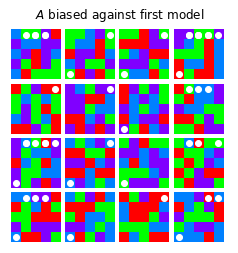

In [14]:
explain(mlp_fae1, '$A$ biased against first model')
plt.show()

Excellent. When we train a model to have small gradients where the $A=0$ model has large ones, we reproduce the top middle rule, though in some cases we learn a hybrid of the two. Now let's train another model to be different from either one. Note: I'm going to iteratively increase the L2 penalty until I get explanation divergence. I'm doing this manually now but it could easily be automated.

In [15]:
A2 = mlp_fae1.largest_gradient_mask(X)
mlp_fae2 = MultilayerPerceptron(l2_grads=1e6)
mlp_fae2.fit(X, y, A2+A1)
mlp_fae2.score(Xt, yt)

[                    ] 0%Iteration=0, crossentropy=Autograd ArrayBox with value 3197.5899268007097, rightreasons=Autograd ArrayBox with value 107699986.4165461, smallparams=Autograd ArrayBox with value 0.005610407176936949, lenX=1.0
[                    ] 3%Iteration=200, crossentropy=Autograd ArrayBox with value 249.77872323200128, rightreasons=Autograd ArrayBox with value 605366.5933471199, smallparams=Autograd ArrayBox with value 0.005231122964099706, lenX=1.0
[=                   ] 7%Iteration=400, crossentropy=Autograd ArrayBox with value 197.13054787437494, rightreasons=Autograd ArrayBox with value 35771.83269203562, smallparams=Autograd ArrayBox with value 0.005197909586295337, lenX=1.0
[==                  ] 11%Iteration=600, crossentropy=Autograd ArrayBox with value 191.1653929168124, rightreasons=Autograd ArrayBox with value 9873.358781192375, smallparams=Autograd ArrayBox with value 0.0051917650864429475, lenX=1.0
[===                 ] 15%Iteration=800, crossentropy=Autogra

0.51565

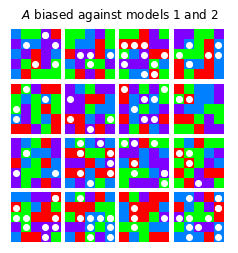

In [16]:
explain(mlp_fae2, '$A$ biased against models 1 and 2')
plt.show()

When we run this twice, we get low accuracy and random gradient placement. Let's visualize this all together:

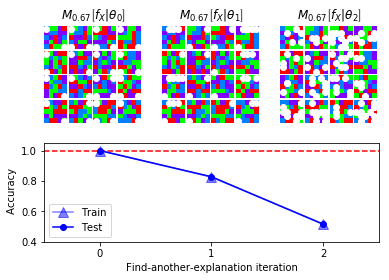

In [17]:
gridsize = (2,3)

plt.subplot2grid(gridsize, (0,0))
explain(mlp_plain, r'$M_{0.67}\left[ f_X|\theta_0 \right]$', 4)

plt.subplot2grid(gridsize, (0,1))
explain(mlp_fae1, r'$M_{0.67}\left[ f_X|\theta_1 \right]$', 4)

plt.subplot2grid(gridsize, (0,2))
explain(mlp_fae2, r'$M_{0.67}\left[ f_X|\theta_2 \right]$', 4)

plt.subplot2grid(gridsize, (1,0), colspan=3)
plt.axhline(1, color='red', ls='--')

test_scores = [mlp_plain.score(Xt, yt), mlp_fae1.score(Xt, yt), mlp_fae2.score(Xt, yt)]
train_scores = [mlp_plain.score(X, y), mlp_fae1.score(X, y), mlp_fae2.score(X, y)]

plt.plot([0,1,2], train_scores, marker='^', label='Train', alpha=0.5, color='blue', markersize=10)
plt.plot([0,1,2], test_scores, marker='o', label='Test', color='blue')
plt.xlim(-0.5, 2.5)
plt.ylim(0.4, 1.05)
plt.ylabel(' Accuracy')
plt.xlabel('Find-another-explanation iteration')
plt.legend(loc='best', fontsize=10)
plt.xticks([0,1,2])
plt.show()

So this more or less demonstrates the find-another-explanation method on the toy color dataset.

## Transitions between rules

Separately, I ran a script to train many MLPs on this dataset, all biased against using corners, but with varying numbers of annotations in $A$ and varying L2 penalties. Let's see if we can find any transition behavior between these two rules:

In [18]:
import pickle
n_vals = pickle.load(open('../data/color_n_vals.pkl', 'rb'))
n_mlps = pickle.load(open('../data/color_n_mlps.pkl', 'rb'))
l2_vals = pickle.load(open('../data/color_l2_vals.pkl', 'rb'))
l2_mlps = pickle.load(open('../data/color_l2_mlps.pkl', 'rb'))

In [19]:
def realize(mlp_params):
  return [MultilayerPerceptron.from_params(p) for p in mlp_params]

l2_rule1_scores = [rule1_score(mlp, Xt[:1000]) for mlp in realize(l2_mlps)]
l2_rule2_scores = [rule2_score(mlp, Xt[:1000]) for mlp in realize(l2_mlps)]
l2_acc_scores = [mlp.score(Xt[:1000], yt[:1000]) for mlp in realize(l2_mlps)]

n_rule1_scores = [rule1_score(mlp, Xt[:1000]) for mlp in realize(n_mlps)]
n_rule2_scores = [rule2_score(mlp, Xt[:1000]) for mlp in realize(n_mlps)]
n_acc_scores = [mlp.score(Xt[:1000], yt[:1000]) for mlp in realize(n_mlps)]

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\matplotlib\axes\_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


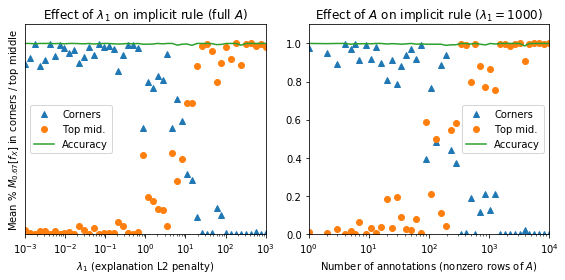

In [20]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(l2_vals, l2_rule1_scores, 'o', label='Corners', marker='^')
plt.plot(l2_vals, l2_rule2_scores, 'o', label='Top mid.')
plt.plot(l2_vals, l2_acc_scores, label='Accuracy')
plt.title('Effect of $\lambda_1$ on implicit rule (full $A$)')
plt.ylabel(r'Mean % $M_{0.67}\left[f_X\right]$ in corners / top middle')
plt.ylim(0,1.1)
plt.xscale("log")
plt.yticks([])
plt.xlim(0,1000)
plt.legend(loc='best', fontsize=10)
plt.xlabel(r'$\lambda_1$ (explanation L2 penalty)')

plt.subplot(122)
plt.plot(n_vals, n_rule1_scores, 'o', label='Corners', marker='^')
plt.plot(n_vals, n_rule2_scores, 'o', label='Top mid.')
plt.plot(n_vals, n_acc_scores, label='Accuracy')
plt.xscale('log')
plt.ylim(0,1.1)
plt.xlim(0,10000)
plt.legend(loc='best', fontsize=10)
plt.title('Effect of $A$ on implicit rule ($\lambda_1=1000$)')
plt.xlabel('Number of annotations (nonzero rows of $A$)')

plt.tight_layout()
plt.show()

Cool. So we can definitely see a clear transition effect between rules.

## Comparison with LIME

Although we have some pretty clear evidence that gradient explanations are descriptive for our MLP on this simple dataset, let's make sure LIME produces similar results. We'll also do a very basic benchmark to see how long each of the respective methods take.

In [21]:
explainer = lime.lime_tabular.LimeTabularExplainer(
  Xt,
  feature_names=list(range(len(Xt[0]))),
  class_names=[0,1])

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [22]:
import time

t1 = time.clock()

lime_explanations = [
  explainer.explain_instance(Xt[i], mlp_plain.predict_proba, top_labels=1)
  for i in range(25)
]

t2 = time.clock()

input_grads = mlp_plain.input_gradients(Xt[:25])

t3 = time.clock()

In [23]:
print('LIME took {:.6f}s/example'.format((t2-t1)/25.))
print('grads took {:.6f}s/example, which is {:.0f}x faster'.format((t3-t2)/25., (t2-t1)/float(t3-t2)))

LIME took 3.029783s/example
grads took 0.000057s/example, which is 52894x faster


In [24]:
preds = mlp_plain.predict(Xt[:25])
lime_exps = [LocalLinearExplanation.from_lime(Xt[i], preds[i], lime_explanations[i]) for i in range(25)]
grad_exps = [LocalLinearExplanation(Xt[i], preds[i], input_grads[i]) for i in range(25)]

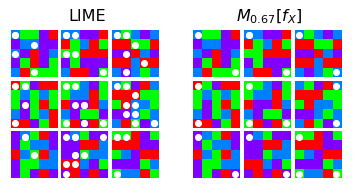

In [25]:
plt.subplot(121)
plt.title('LIME', fontsize=16)
explanation_grid(lime_exps, imgshape, 3)
plt.subplot(122)
plt.title(r'$M_{0.67}\left[f_X\right]$', fontsize=16)
explanation_grid(grad_exps, imgshape, 3)
plt.show()

So our explanation methods agree somewhat closely, which is good to see. Also, gradients are significantly faster.

## Learning from less data

Do explanations allow our model to learn with less data? Separately, we trained many models on increasing fractions of the dataset with different annotations; some penalizing the corners/top-middle and some penalizing everything but the corners/top-middle. Let's see how each version of the model performs:

In [26]:
import pickle

data_counts = pickle.load(open('../data/color_data_counts.pkl', 'rb'))
normals_by_count  = pickle.load(open('../data/color_normals_by_count.pkl', 'rb'))
pro_r1s_by_count  = pickle.load(open('../data/color_pro_r1s_by_count.pkl', 'rb'))
pro_r2s_by_count  = pickle.load(open('../data/color_pro_r2s_by_count.pkl', 'rb'))
anti_r1s_by_count = pickle.load(open('../data/color_anti_r1s_by_count.pkl', 'rb'))
anti_r2s_by_count = pickle.load(open('../data/color_anti_r2s_by_count.pkl', 'rb'))

In [27]:
def score_all(ms):
  return [m.score(Xt,yt) for m in realize(ms)]

def realize(mlp_params):
  return [MultilayerPerceptron.from_params(p) for p in mlp_params]

sc_normal = score_all(normals_by_count)
sc_pro_r1 = score_all(pro_r1s_by_count)
sc_pro_r2 = score_all(pro_r2s_by_count)
sc_anti_r1 = score_all(anti_r1s_by_count)
sc_anti_r2 = score_all(anti_r2s_by_count)

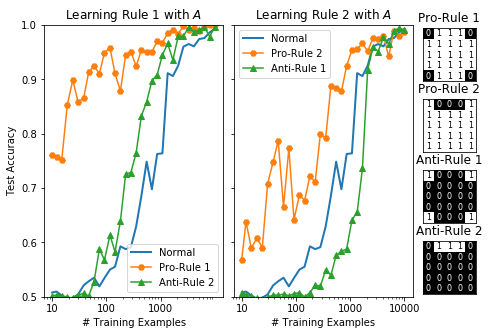

In [28]:
from matplotlib import ticker

def plot_A(A):
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.imshow((A[0].reshape(5,5,3) * 255).astype(np.uint8), interpolation='none')
  for i in range(5):
    for j in range(5):
      if A[0].reshape(5,5,3)[i][j][0]:
        plt.text(j,i+0.025,'1',ha='center',va='center',fontsize=8)
      else:
        plt.text(j,i+0.025,'0',ha='center',va='center',color='white',fontsize=8)

gridsize = (4,9)
plt.figure(figsize=(10,5))
cs=3

plt.subplot2grid(gridsize, (0,2*cs))
plt.title('Pro-Rule 1')
plot_A(~E2)

plt.subplot2grid(gridsize, (1,2*cs))
plt.title('Pro-Rule 2')
plot_A(~E1)

plt.subplot2grid(gridsize, (2,2*cs))
plt.title('Anti-Rule 1')
plot_A(E2)

plt.subplot2grid(gridsize, (3,2*cs))
plt.title('Anti-Rule 2')
plot_A(E1)

plt.subplot2grid(gridsize, (0,0), rowspan=4, colspan=cs)
plt.title('Learning Rule 1 with $A$')
plt.errorbar(data_counts, sc_normal, label=r'Normal', lw=2)
plt.errorbar(data_counts, sc_pro_r1, label=r'Pro-Rule 1', marker='H')
plt.errorbar(data_counts, sc_anti_r2, label=r'Anti-Rule 2', marker='^')
plt.xscale('log')
plt.ylim(0.5,1)
plt.ylabel('Test Accuracy')
plt.xlabel('# Training Examples')
plt.legend(loc='best', fontsize=10)
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
plt.gca().set_xticks([10,100,1000])

plt.subplot2grid(gridsize, (0,cs), rowspan=4, colspan=cs)
plt.title('Learning Rule 2 with $A$')
plt.gca().set_yticklabels([])
plt.errorbar(data_counts, sc_normal, label=r'Normal', lw=2)
plt.errorbar(data_counts, sc_pro_r2, label=r'Pro-Rule 2', marker='H')
plt.errorbar(data_counts, sc_anti_r1, label=r'Anti-Rule 1', marker='^')
plt.xscale('log')
plt.ylim(0.5,1)
plt.xlabel('# Training Examples')
plt.legend(loc='best', fontsize=10)
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))

plt.show()

In [29]:
def improvement_over_normal(scores, cutoff):
  norm = data_counts[next(i for i,val in enumerate(sc_normal) if val > cutoff)]
  comp = data_counts[next(i for i,val in enumerate(scores) if val > cutoff)]
  return norm / float(comp)

def print_improvement(name, scores, cutoff):
  print('Extra data for normal model to reach {:.2f} accuracy vs. {}: {:.2f}'.format(
      cutoff, name, improvement_over_normal(scores, cutoff)))

print_improvement('Anti-Rule 2', sc_anti_r2, 0.8)
print_improvement('Anti-Rule 2', sc_anti_r2, 0.9)
print_improvement('Anti-Rule 2', sc_anti_r2, 0.95)
print_improvement('Anti-Rule 2', sc_anti_r2, 0.99)
print('')
print_improvement('Pro-Rule 1', sc_pro_r1, 0.8)
print_improvement('Pro-Rule 1', sc_pro_r1, 0.9)
print_improvement('Pro-Rule 1', sc_pro_r1, 0.95)
print_improvement('Pro-Rule 1', sc_pro_r1, 0.99)
print('')
print_improvement('Pro-Rule 2', sc_pro_r2, 0.9)
print_improvement('Pro-Rule 2', sc_pro_r2, 0.95)
print_improvement('Pro-Rule 2', sc_pro_r2, 0.97)
print('')
print_improvement('Anti-Rule 1', sc_anti_r1, 0.7)
print_improvement('Anti-Rule 1', sc_anti_r1, 0.8)
print_improvement('Anti-Rule 1', sc_anti_r1, 0.9)

Extra data for normal model to reach 0.80 accuracy vs. Anti-Rule 2: 3.05
Extra data for normal model to reach 0.90 accuracy vs. Anti-Rule 2: 1.56
Extra data for normal model to reach 0.95 accuracy vs. Anti-Rule 2: 1.95
Extra data for normal model to reach 0.99 accuracy vs. Anti-Rule 2: 3.05

Extra data for normal model to reach 0.80 accuracy vs. Pro-Rule 1: 70.79
Extra data for normal model to reach 0.90 accuracy vs. Pro-Rule 1: 28.62
Extra data for normal model to reach 0.95 accuracy vs. Pro-Rule 1: 22.64
Extra data for normal model to reach 0.99 accuracy vs. Pro-Rule 1: 5.95

Extra data for normal model to reach 0.90 accuracy vs. Pro-Rule 2: 1.56
Extra data for normal model to reach 0.95 accuracy vs. Pro-Rule 2: 2.44
Extra data for normal model to reach 0.97 accuracy vs. Pro-Rule 2: 1.95

Extra data for normal model to reach 0.70 accuracy vs. Anti-Rule 1: 0.33
Extra data for normal model to reach 0.80 accuracy vs. Anti-Rule 1: 0.64
Extra data for normal model to reach 0.90 accuracy v

Generally, we learn better classifiers with less data using explanations (especially in the Pro-Rule 1 case, where we provide the most information). Biasing against the top-middle or against everything but the corners / top-middle tends to give us more accurate classifiers. Biasing against the corners, however, gives us _lower_ accuracy until we obtain more examples. This may be because it's an inherently harder rule to learn; there are only 4 ways that all corners can match, but $4*3*2=24$ ways the top-middle pixels can differ.

## Investigating cutoffs 

We chose a 0.67 cutoff for most of our training a bit arbitrarily, so let's just investigate that briefly:

In [30]:
def M(input_gradients, cutoff=0.67):
  return np.array([np.abs(e) > cutoff*np.abs(e).max() for e in input_gradients]).astype(int).ravel()

grads = mlp_plain.input_gradients(Xt)
grads2 = mlp_rule1.input_gradients(Xt)

cutoffs = np.linspace(0,1,100)
cutoff_pcts = np.array([M(grads, c).sum() / float(len(grads.ravel())) for c in cutoffs])
cutoff_pcts2 = np.array([M(grads2, c).sum() / float(len(grads2.ravel())) for c in cutoffs])

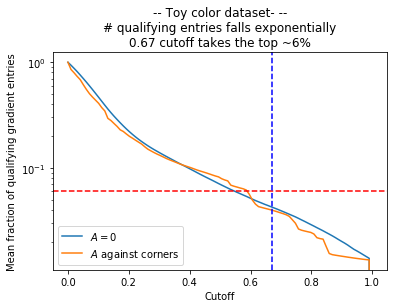

In [31]:
plt.plot(cutoffs, cutoff_pcts, label='$A=0$')
plt.plot(cutoffs, cutoff_pcts2, label='$A$ against corners')
plt.legend(loc='best')
plt.xlabel('Cutoff')
plt.ylabel('Mean fraction of qualifying gradient entries')
plt.yticks(np.linspace(0,1,21))
plt.yscale('log')
plt.axhline(0.06, ls='--', c='red')
plt.axvline(0.67, ls='--', c='blue')
plt.title('-- Toy color dataset- --\n# qualifying entries falls exponentially\n0.67 cutoff takes the top ~6%')
plt.show()

On average, the number of elements we keep falls exponentially without any clear kink in the curve, so perhaps our arbitrariness is justified, though it's problematic that it exists in the first place.